In [200]:
import pickle
import sncosmo
import numpy as np
import lsst.daf.base as dafBase
import lsst.daf.persistence as dafPersist

import re

import lsst.afw.display.ds9 as ds9

import matplotlib.pyplot as plt

from lsst.ip.diffim import ImagePsfMatchTask, DipoleMeasurementTask
from lsst.meas.base import SingleFrameMeasurementConfig
import lsst.afw.table as afwTable

import lsst.daf.base as dafBase
import DiaSourceTools as DSTools

import lsst.meas.algorithms.detection as sDet
import lsst.afw.image as afwImage

from lsst.meas.algorithms.detection import SourceDetectionTask

import lsst.afw.geom as afwGeom
import random
%matplotlib inline

In [139]:
algMetadata = dafBase.PropertyList()
schema = afwTable.SourceTable.makeMinimalSchema()

dipoleMeasurement = dipoleMeasurer.DipoleMeasurementTask
config = dipoleMeasurement.ConfigClass()
dipoleMeasurement = dipoleMeasurement(schema, algMetadata=algMetadata)

In [140]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
diffExp1 = butler.get("deepDiff_differenceExp", {'visit': 849687 , 'filter':'r' , 'ccd':14})
diaSrcs1 = butler.get("deepDiff_diaSrc", {'visit': 849687 , 'filter':'r' , 'ccd':14})

In [141]:
def SubtractBackground(exp):
  
    bgConf = sDet.BackgroundConfig()
    background,Exp0 = sDet.estimateBackground(exp,bgConf,True)

    return background, Exp0

In [142]:
bg, ex = SubtractBackground(diffExp1)

In [143]:
psf = diffExp1.getPsf()
shape = psf.computeShape()
sigma = shape.getDeterminantRadius()


In [144]:
threshold=4


table = afwTable.SourceTable.make(schema)
table.setMetadata(algMetadata)

config = SourceDetectionTask.ConfigClass()
config.thresholdPolarity = "both"
config.thresholdValue = threshold
config.reEstimateBackground = False
config.thresholdType = "pixel_stdev"

detectionTask = SourceDetectionTask(config=config, schema=schema)
table = afwTable.SourceTable.make(schema)
results = detectionTask.makeSourceCatalog(table=table, exposure=diffExp1 , doSmooth=False )

print len(results.sources)

3327


In [145]:
fpSet = results.fpSets.positive
fpSet.merge(results.fpSets.negative, 2,
            2, False)
diaSources = afwTable.SourceCatalog(table)
fpSet.makeSources(diaSources)


In [146]:
dipoleMeasurement.run(diaSources, diffExp1)

In [147]:
print len(diaSources)
ds = remove_nan_sources(diaSources)
print len(ds)

2961
2955


In [85]:
c_diaSrcs = []

for diaSrc in diaSources:
    val = diaSrc.get("coord_ra").asArcseconds()
    if np.isnan(val) == False:
        diaSources.getTable()
    


# Part 2: Stamps

In [464]:
def merge_sources(results):
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, 2, 2, False)
    diaSources = afwTable.SourceCatalog(table)
    fpSet.makeSources(diaSources)
    return diaSources

def remove_nan_sources(diaSources):
    c_diaSources = diaSources.copy()
    c_diaSources.clear()
    for diaSrc in diaSources:
        val = diaSrc.get("coord_ra").asArcseconds()
        if np.isnan(val) == False:
            c_diaSources.append(diaSrc)
        
    return c_diaSources

def get_source_stamp(src, visit, ccds, offset=0):
    
    for ccd in ccds:

        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd}):

            diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd})
            bbox = diffExp.getBBox()
            wcs = diffExp.getWcs()
            
            c = afwGeom.Point2I(wcs.skyToPixel(src.getRa(), src.getDec()))
            
            if bbox.contains(c):
                psf = diffExp.getPsf()
                shape = psf.computeShape()
                sigma = shape.getDeterminantRadius()
                print sigma
                
                return DSTools.get_stamp(src, diffExp, offset=offset), c
            
    return None, None  

In [500]:
visit = 849687
filter = 'r'

source_catalogs = [None, None, None]

ccds = butler.queryMetadata("deepDiff_differenceExp", format=['ccd'],dataId={'filter':filter})

#ccds = [14,15, 16, 17]

for ccd in ccds:

        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd}):

            diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd})
            
            
            
            for i in range(4,7):
                    try:
                        results = DSTools.detect_diasources(diffExp, doSmooth=False, threshold=i)
                        diaSources = merge_sources(results)
                        dipoleMeasurement.run(diaSources, diffExp)
                        diaSources = remove_nan_sources(diaSources)

                        if source_catalogs[i-4] == None:
                            source_catalogs[i-4] = diaSources
                        else:
                            source_catalogs[i-4].extend(diaSources)
                    except Exception, e:
                        print e


float division by zero


In [511]:
catalog_s5 = source_catalogs[2]

source = random.choice(catalog_5)
 

In [512]:
stamp, center = get_source_stamp(source, visit, ccds, offset=10)

if stamp is not None:
    ds9.mtv(stamp, frame=1)
    ds9.dot('+', center.getX(), center.getY(), ctype=ds9.RED, frame=1)
    

mi = stamp.clone().getMaskedImage()
mask = mi.getMask()

mask &= (~mask.getPlaneBitMask("DETECTED"))
mask &= (~mask.getPlaneBitMask("DETECTED_NEGATIVE"))

fp = source.getFootprint()

mplane = mask.addMaskPlane("CORR_DETECTED")

w = stamp.getWidth()
h = stamp.getHeight()

for i in range(w):
    for j in range (h):
        if fp.contains(afwGeom.Point2I(i+stamp.getX0(),j+stamp.getY0())):
            #print True
            mask[i,j] = mplane
            
ds9.mtv(stamp, frame=2)
ds9.dot('+', center.getX(), center.getY(), ctype=ds9.RED, frame=2)

mask &= (~mask.getPlaneBitMask("CORR_DETECTED"))

1.83352084006
Box2I((1082, 3814), (1115, 3847)) Box2I((1091, 3824), (1103, 3836))


In [513]:
stamp_clone = stamp.clone()
results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=5)

ds9.mtv(stamp_clone, frame=3)

In [504]:
t =1.78846662059*6

stamp_th = stamp.clone()

stamp_im = stamp_th.getMaskedImage().getImage()
im = stamp_im.getArray()
for x in range(stamp_im.getHeight()):
    for y in range(stamp_im.getWidth()):
        if np.abs(stamp_im.get(x,y)) > t:
            stamp_im.set(x,y,1)
        else:
            stamp_im.set(x,y,0)
            
            
ds9.mtv(stamp_im, frame=4)

LengthError: 
  File "src/image/Image.cc", line 278, in lsst::afw::image::ImageBase<PixelT>::PixelReference lsst::afw::image::ImageBase<PixelT>::operator()(int, int, const lsst::afw::image::CheckIndices&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::PixelReference = float&]
    Index (43, 0) is out of range [0--42], [0--44] {0}
lsst::pex::exceptions::LengthError: 'Index (43, 0) is out of range [0--42], [0--44]'


In [525]:
t =7*6

stamp_th = diffExp.clone()

stamp_im = stamp_th.getMaskedImage().getImage()
im = stamp_im.getArray()
for x in range(stamp_im.getWidth()):
    for y in range(stamp_im.getHeight()):
        if np.abs(stamp_im.get(x,y)) > t:
            stamp_im.set(x,y,1)
        else:
            stamp_im.set(x,y,0)
            
            
ds9.mtv(stamp_im, frame=5)

In [498]:
ds9.mtv(diffExp, frame=6)

In [519]:
import skimage
from skimage import measure
from skimage import data
from skimage import filters

In [520]:
n = 20
l = 256
im = np.zeros((l, l))
points = l * np.random.random((2, n ** 2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = filters.gaussian_filter(im, sigma=l / (4. * n))
blobs = im > im.mean()

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):


In [527]:
blobs = stamp_im.getArray()

In [539]:

all_labels = measure.label(res)
blobs_labels = measure.label(res, background=0)

In [535]:
from scipy import ndimage


res = ndimage.binary_opening(blobs, np.ones((3,3)).astype(np.int))

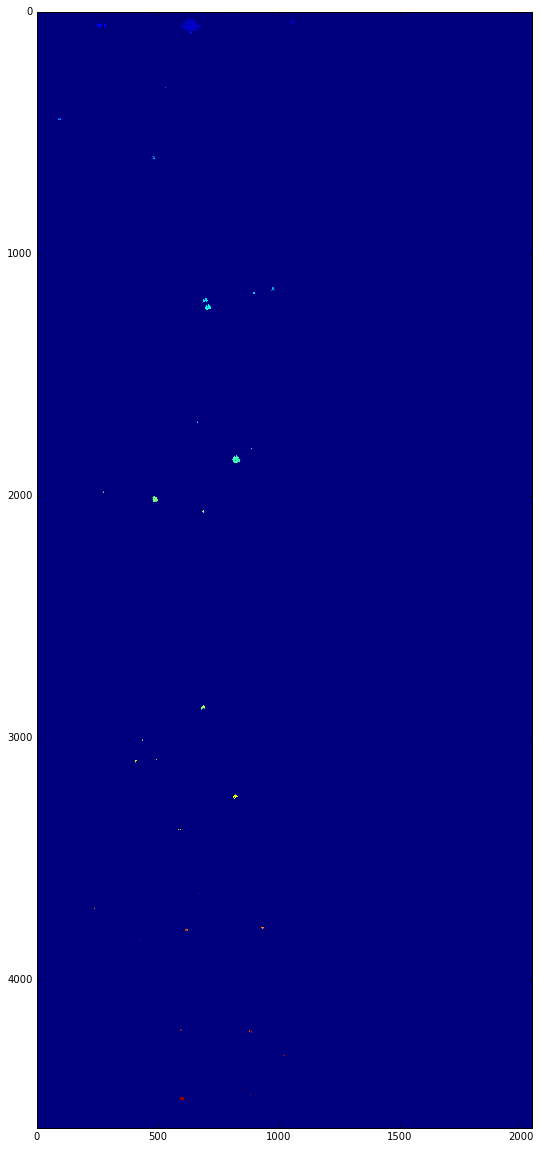

In [540]:
import matplotlib.pyplot as plt
plt.figure(figsize=(101,20))
plt.imshow(blobs_labels) 

In [524]:
ds9.mtv(stamp_im, frame=5)